# Parallel Data Processing

## Objectives

* Program parallel statistical methods to be used for some basic data analisis.
* Compare the methods with numpy mwthods for identify it's performance characteristics.

## Mathematical Tools

For total transparency this project doesn't use any direct advanced mathematical tools, since all these methods are very basic from a mathematical point of view. On the other hand there is a basic visualization of the presented data as a tool for understanding our comparison. In the development of the project there was also a long process of revision over the alternatives for the implementation, comparison between them for determining wich would have the best performance characteristics. Finally, we chose to ideally communicate directly to the machine using various low level access. Due to our inability to replicate the efficiency of BLAS instructions we are not currently par with Numpy performance-wise.

## Libraries

* Numpy: Our adversary.
* Numpy(Rust): Interface for be able to receive Numpy types directly.
* Ndarray: Basic datastructure for manipulation in Rust.
* PyO3: Python bindings for Rust.
* Maturin: Compilation helper.
* Matplotlib, Seaborn: For graphs.
* Some minor ergonomics libraries.

## Technical Tools

* SIMD (SSE, SSE2, AVX, AVX2): Assembly instruction sets used in the simd implementations for great performance using data parallelization in hardware and intrinsics for easy use.
* Parallelization: Use of multiple cores for get a perfromance boost for the application.

## Parallelization Options

We checked multiple parallel options:

* Channels for message pass.
* Threads with mutex data sharing.
* data copy to multiple threads.

Our analysis for this options was:

* Avoid channels for big complexity and dismished parallelization.
* Avoid mutex for data sharing due to the limited data access it create.
* Avoid data copy for the extreme overhead that generates.

Finally we choose to use threads with direct access to memory for avoid any overhead from safe access or multiple copying.

## Results

In [1]:
from typing import Callable
from time import perf_counter
from itertools import chain
import parallel_data_processing_rs as rs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.set_palette("deep")

In [2]:
data = np.array([x for x in range (1, 100)], dtype=np.float64)

assert(rs.sum(data) == data.sum())
assert(rs.mean(data) == data.mean())
assert(rs.var(data) == data.var())
assert(rs.stdev(data) == data.std())
assert(rs.max(data) == data.max())
assert(rs.min(data) == data.min())
assert(rs.sum_simd(data) == data.sum())
assert(rs.mean_simd(data) == data.mean())
assert(rs.var_simd(data) == data.var())
assert(rs.stdev_simd(data) == data.std())
assert(rs.max_simd(data) == data.max())
assert(rs.min_simd(data) == data.min())


In [3]:
def plain_syntetic_test(rsfn: Callable, simdfn: Callable, npfn: Callable):
    size_sets = tuple(
        tuple(i for i in range(10 ** e, 10 ** (e + 1), 10 ** (e - 1)))
        for e in range(2, 8)
    )
    time_data_rs = []
    time_data_np = []
    time_data_simd = []
    for size_set in size_sets:
        time_data_set_rs = []
        time_data_set_np = []
        time_data_set_simd = []
        for i in size_set:
            test_data = np.arange(0, i, dtype=np.float64)
            rs_times = []
            for _ in range(10):
                start = perf_counter()
                rsfn(test_data)
                time = perf_counter() - start
                rs_times.append(time)
            simd_times = []
            for _ in range(10):
                start = perf_counter()
                simdfn(test_data)
                time = perf_counter() - start
                simd_times.append(time)
            np_times = []
            for _ in range(10):
                start = perf_counter()
                npfn(test_data)
                time = perf_counter() - start
                np_times.append(time)
            time_data_set_rs.append(np.mean(rs_times))
            time_data_set_simd.append(np.mean(simd_times))
            time_data_set_np.append(np.mean(np_times))
        time_data_rs.append(tuple(time_data_set_rs))
        time_data_simd.append(tuple(time_data_set_simd))
        time_data_np.append(tuple(time_data_set_np))
    return size_sets, tuple(time_data_rs), tuple(time_data_simd), tuple(time_data_np)

### Sum

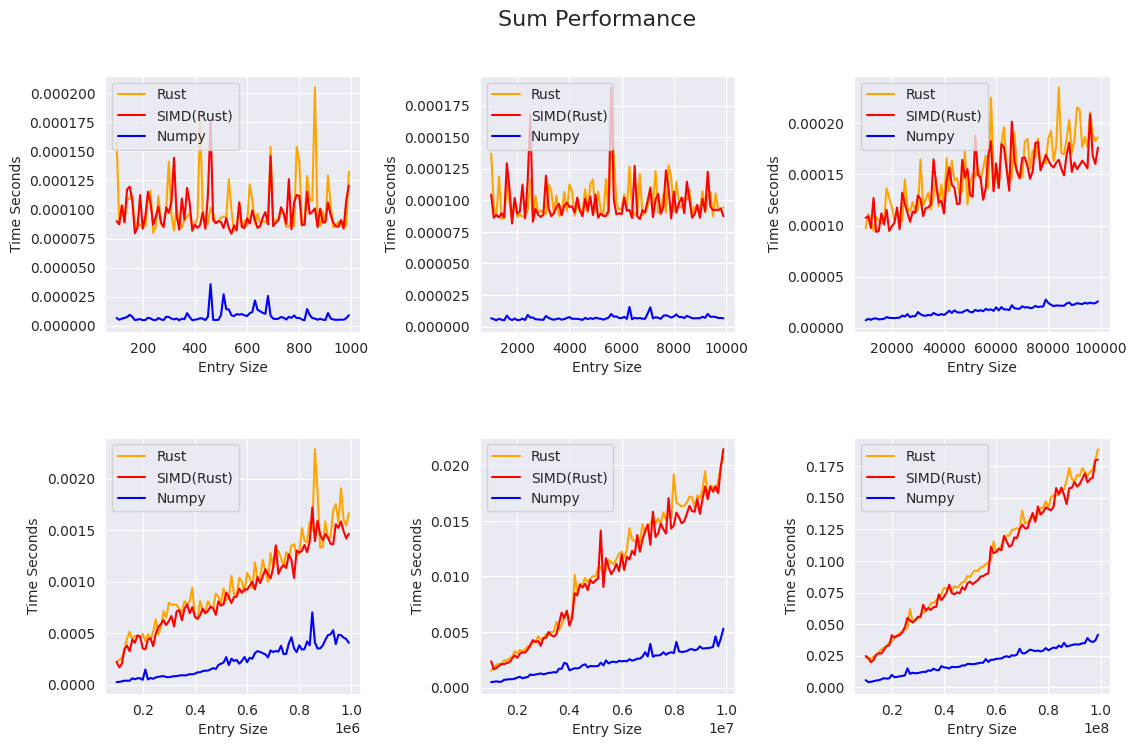

In [4]:
size_sets, sum_time_rs, sum_time_simd, sum_time_np = plain_syntetic_test(rs.sum, rs.sum_simd, np.ndarray.sum)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.tight_layout(pad=5.5)
fig.suptitle("Sum Performance", fontsize=16)

for i, axs in enumerate(chain(*axes)):
    axs.plot(size_sets[i], sum_time_rs[i], color="orange", label="Rust")
    axs.plot(size_sets[i], sum_time_simd[i], color="red", label="SIMD(Rust)")
    axs.plot(size_sets[i], sum_time_np[i], color="blue", label="Numpy")
    axs.set_xlabel("Entry Size")
    axs.set_ylabel("Time Seconds")
    axs.tick_params(labelsize=10)
    axs.legend(loc="upper left")

### Mean

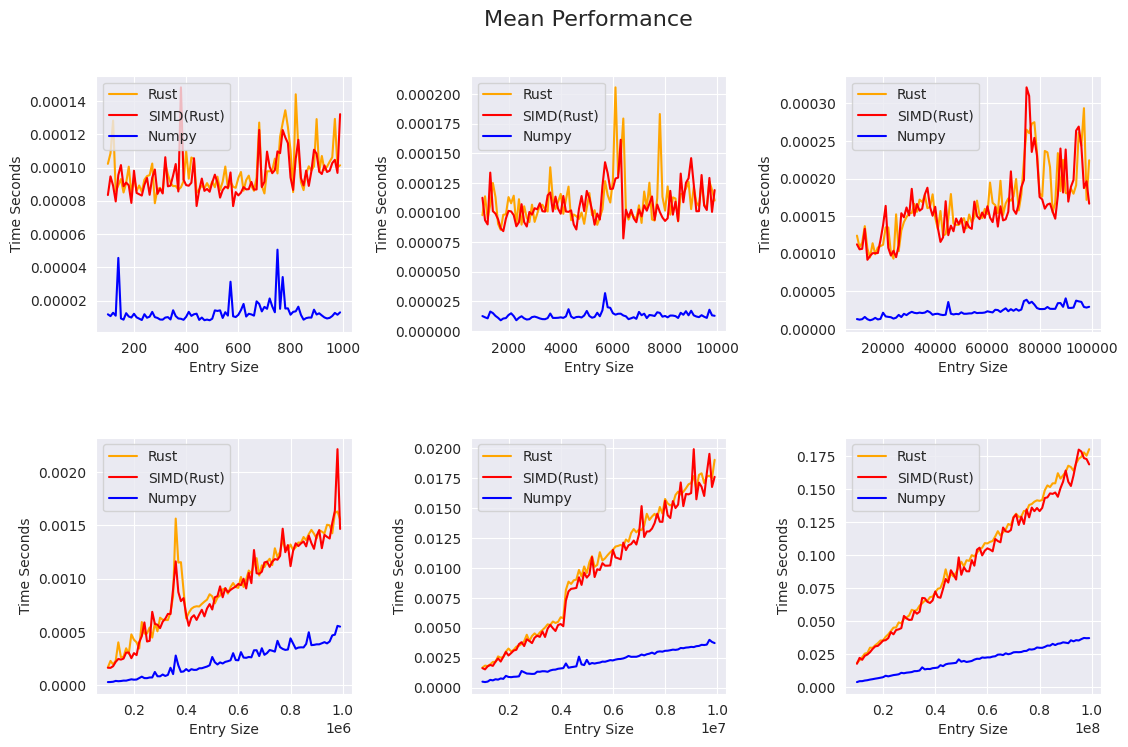

In [5]:
size_sets, mean_time_rs, mean_time_simd, mean_time_np = plain_syntetic_test(rs.mean, rs.mean_simd, np.ndarray.mean)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.tight_layout(pad=5.5)
fig.suptitle("Mean Performance", fontsize=16)

for i, axs in enumerate(chain(*axes)):
    axs.plot(size_sets[i], mean_time_rs[i], color="orange", label="Rust")
    axs.plot(size_sets[i], mean_time_simd[i], color="red", label="SIMD(Rust)")
    axs.plot(size_sets[i], mean_time_np[i], color="blue", label="Numpy")
    axs.set_xlabel("Entry Size")
    axs.set_ylabel("Time Seconds")
    axs.tick_params(labelsize=10)
    axs.legend(loc="upper left")

### Variance

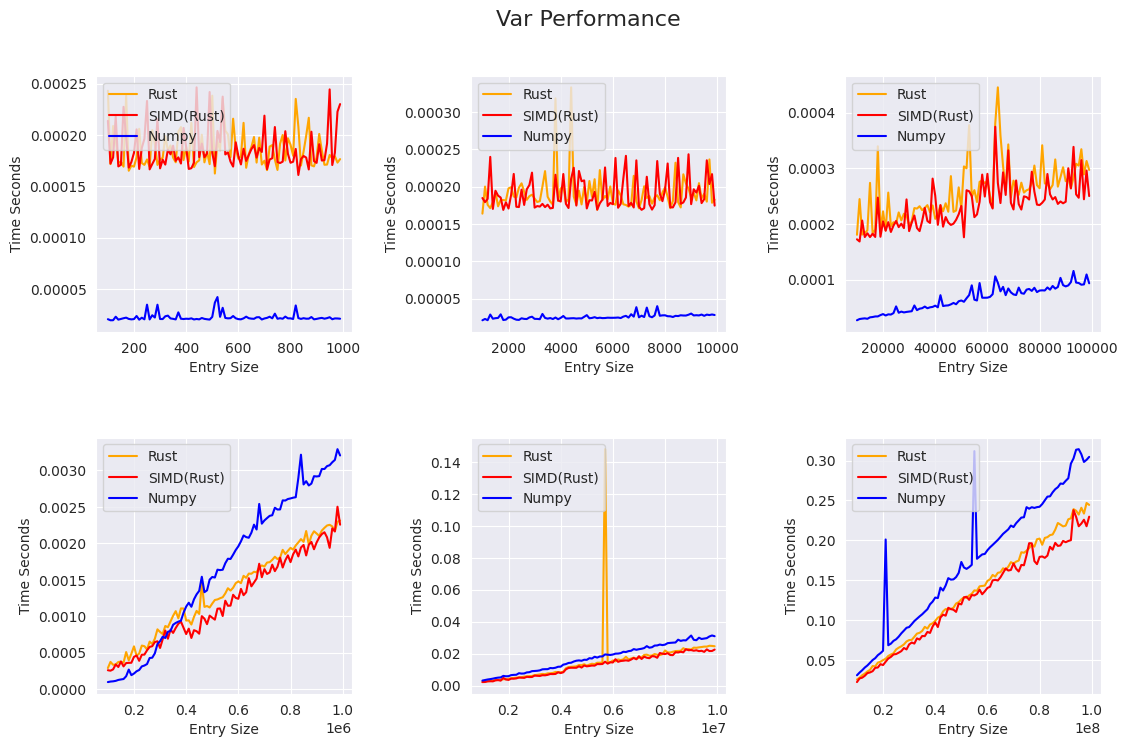

In [6]:
size_sets, var_time_rs, var_time_simd, var_time_np = plain_syntetic_test(rs.var, rs.var_simd, np.ndarray.var)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.tight_layout(pad=5.5)
fig.suptitle("Var Performance", fontsize=16)

for i, axs in enumerate(chain(*axes)):
    axs.plot(size_sets[i], var_time_rs[i], color="orange", label="Rust")
    axs.plot(size_sets[i], var_time_simd[i], color="red", label="SIMD(Rust)")
    axs.plot(size_sets[i], var_time_np[i], color="blue", label="Numpy")
    axs.set_xlabel("Entry Size")
    axs.set_ylabel("Time Seconds")
    axs.tick_params(labelsize=10)
    axs.legend(loc="upper left")

### Standard Deviation

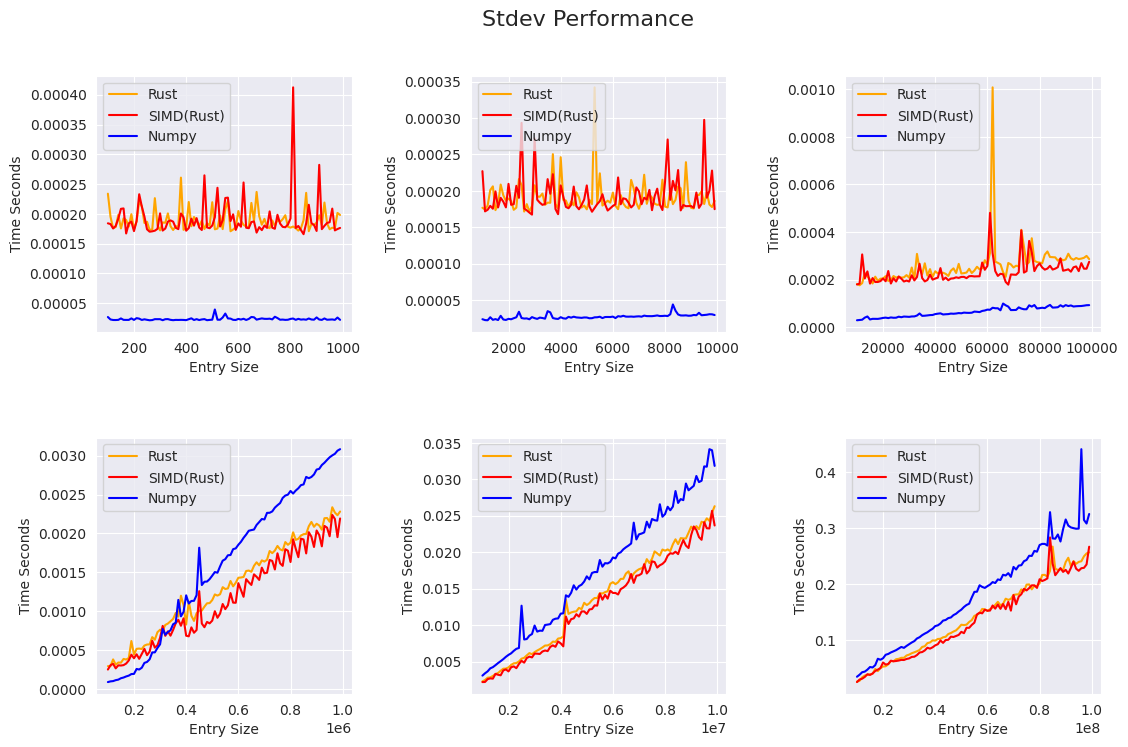

In [7]:
size_sets, stdev_time_rs, stdev_time_simd, stdev_time_np = plain_syntetic_test(rs.stdev, rs.stdev_simd, np.ndarray.std)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.tight_layout(pad=5.5)
fig.suptitle("Stdev Performance", fontsize=16)

for i, axs in enumerate(chain(*axes)):
    axs.plot(size_sets[i], stdev_time_rs[i], color="orange", label="Rust")
    axs.plot(size_sets[i], stdev_time_simd[i], color="red", label="SIMD(Rust)")
    axs.plot(size_sets[i], stdev_time_np[i], color="blue", label="Numpy")
    axs.set_xlabel("Entry Size")
    axs.set_ylabel("Time Seconds")
    axs.tick_params(labelsize=10)
    axs.legend(loc="upper left")

### Max

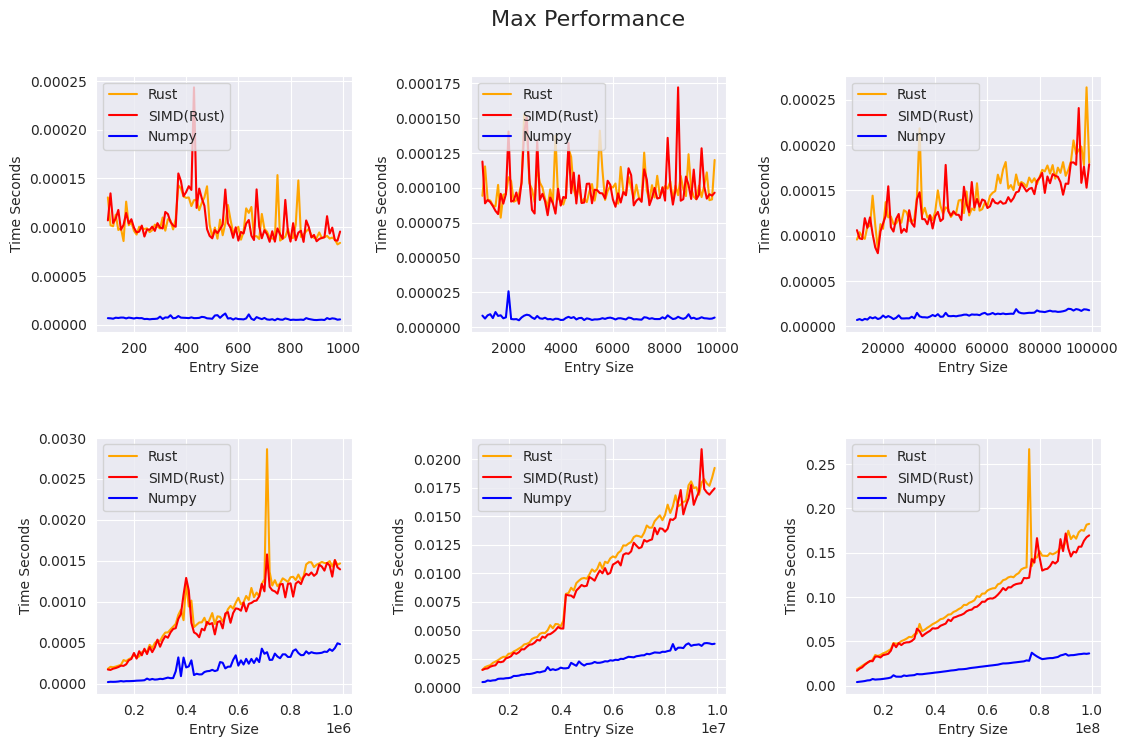

In [8]:
size_sets, max_time_rs, max_time_simd, max_time_np = plain_syntetic_test(rs.max, rs.max_simd, np.ndarray.max)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.tight_layout(pad=5.5)
fig.suptitle("Max Performance", fontsize=16)

for i, axs in enumerate(chain(*axes)):
    axs.plot(size_sets[i], max_time_rs[i], color="orange", label="Rust")
    axs.plot(size_sets[i], max_time_simd[i], color="red", label="SIMD(Rust)")
    axs.plot(size_sets[i], max_time_np[i], color="blue", label="Numpy")
    axs.set_xlabel("Entry Size")
    axs.set_ylabel("Time Seconds")
    axs.tick_params(labelsize=10)
    axs.legend(loc="upper left")

### Min

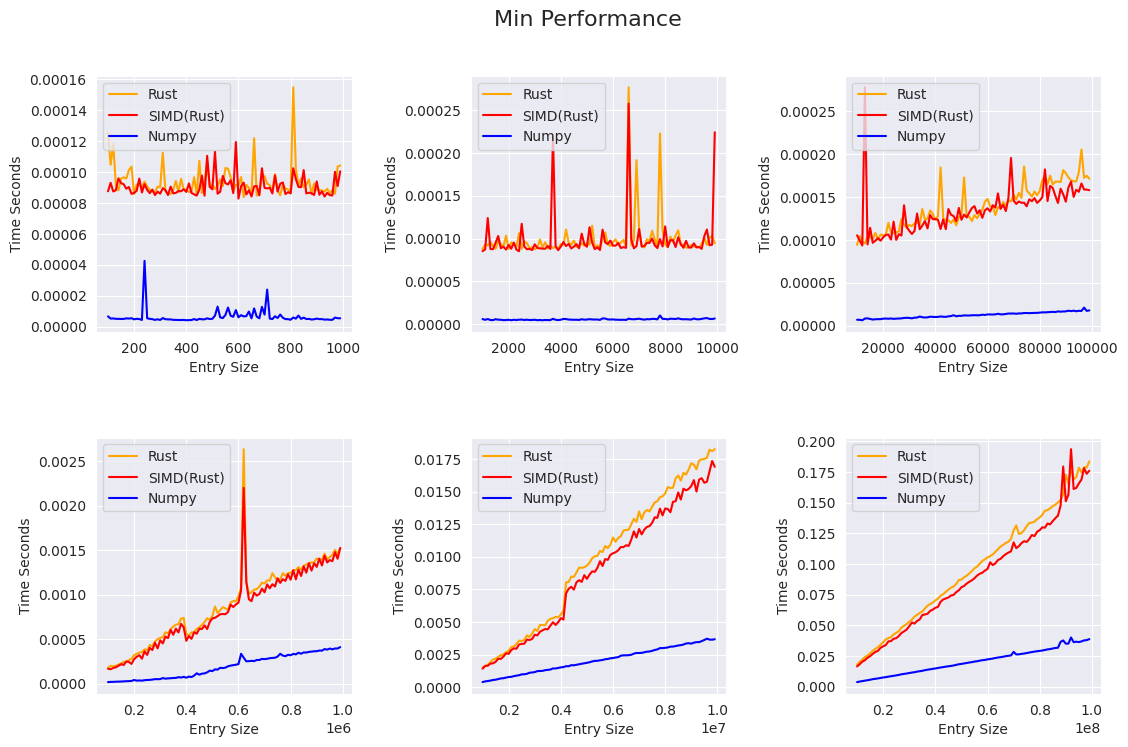

In [9]:
size_sets, min_time_rs, min_time_simd, min_time_np = plain_syntetic_test(rs.min, rs.min_simd, np.ndarray.min)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.tight_layout(pad=5.5)
fig.suptitle("Min Performance", fontsize=16)

for i, axs in enumerate(chain(*axes)):
    axs.plot(size_sets[i], min_time_rs[i], color="orange", label="Rust")
    axs.plot(size_sets[i], min_time_simd[i], color="red", label="SIMD(Rust)")
    axs.plot(size_sets[i], min_time_np[i], color="blue", label="Numpy")
    axs.set_xlabel("Entry Size")
    axs.set_ylabel("Time Seconds")
    axs.tick_params(labelsize=10)
    axs.legend(loc="upper left")